In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Dataset loader definition**

['/content/drive/MyDrive/UNET/Data_new/Training + validation/images/1.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/10.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/100.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/101.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/102.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/104.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/105.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/106.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/107.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/108.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/109.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/11.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/110.tif', '/

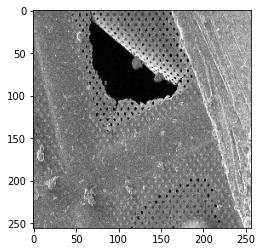

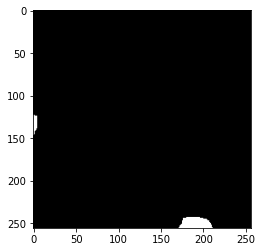

validation instance


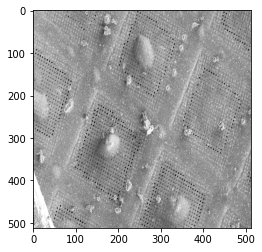

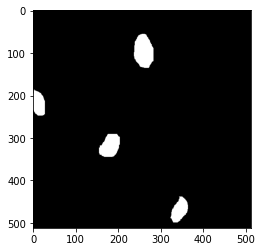

testing instance


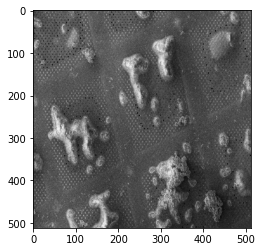

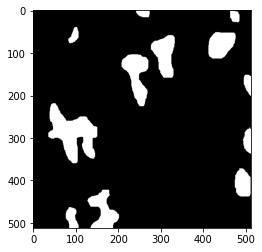

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F  
import torch.optim as optim
import torchvision

import glob
import os
from skimage.io import imread
import cv2

from skimage.color import rgb2gray
import torchvision.transforms.functional as TF

class DataSet(torch.utils.data.Dataset):
    def __init__(self, split="Training + validation", path_to_data='/content/drive/MyDrive/UNET/Data_new', fold = 0, isval = True):
        self.split = split
        self.path = path_to_data + '/' + split 
        self.isval = isval

        self.files_img = glob.glob(self.path + '/images/*')
        self.files_mask = glob.glob(self.path + '/masks/*')
        self.files_img.sort()
        self.files_mask.sort()

        start_index = fold*200    # for cross-validation fold split
        end_index = fold*200 + 200

        self.img_filepaths = []  
        self.mask_filepaths = []  

        if split == "Training + validation":  # for dataset augmentation
          self.files_img=self.files_img*10
          self.files_mask=self.files_mask*10

          for i in range(len(self.files_img)):  # separating training and validation fold
            if isval:
              if start_index <= i and i < end_index:
                self.img_filepaths.append(self.files_img[i])
                self.mask_filepaths.append(self.files_mask[i])
            else:
              if start_index > i or i >= end_index:
                self.img_filepaths.append(self.files_img[i])
                self.mask_filepaths.append(self.files_mask[i])
        else:
          self.img_filepaths = self.files_img 
          self.mask_filepaths = self.files_mask
      
        print(self.img_filepaths)
        print(self.mask_filepaths)

        self.num_of_imgs = len(self.img_filepaths)
        print('Number of images: '+ str(len(self.img_filepaths)))

    def __len__(self):
        return self.num_of_imgs



    def __getitem__(self, index):
        img = imread(self.img_filepaths[index]).astype('uint8')
        mask = imread(self.mask_filepaths[index]).astype('uint8')

        img = rgb2gray(img).astype(np.float32)
        mask = rgb2gray(mask).astype(np.float32)

        img = cv2.resize(img,(512, 512))
        mask = cv2.resize(mask,(512, 512))
        
        mask = mask > 0.5

        H = img.shape[0]
        W = img.shape[1]

        img_size=(round(W/2), round(H/2))

        if self.split == "Training + validation" and self.isval == False:  # dataset augmentation
            img,mask = self.random_crop((H, W),img_size,img,mask)
            img,mask = self.random_rotflip(img,mask)

        img = TF.to_tensor(img)
        mask = TF.to_tensor(mask)

        return img,mask



    def random_crop(self,in_size,out_size,img,mask):

        r = [int(torch.randint(in_size[0]-out_size[0],(1,1)).view(-1).numpy()),int(torch.randint(in_size[1]-out_size[1],(1,1)).view(-1).numpy())]

        img_crop = img[r[0]:r[0]+out_size[0],r[1]:r[1]+out_size[1]]
        mask_crop = mask[r[0]:r[0]+out_size[0],r[1]:r[1]+out_size[1]]

        return img_crop.copy(), mask_crop.copy()



    def random_rotflip(self,img,mask):

        r = [torch.randint(2,(1,1)).view(-1).numpy(), torch.randint(2,(1,1)).view(-1).numpy(), torch.randint(4,(1,1)).view(-1).numpy()]

        if r[0]:
            img = np.fliplr(img)
            mask = np.fliplr(mask)
        if r[1]:
            img = np.flipud(img)
            mask = np.flipud(mask)

        img = np.rot90(img, k = r[2])
        mask = np.rot90(mask, k = r[2]) 

        return img.copy(), mask.copy()
    

      
loader = DataSet(split='Training + validation', fold = 0, isval = False)
trainloader = torch.utils.data.DataLoader(loader, batch_size=1, num_workers=4, shuffle=True, pin_memory=True)

loader = DataSet(split='Training + validation', fold = 0, isval = True)
validloader = torch.utils.data.DataLoader(loader, batch_size=1, num_workers=4, shuffle=True, pin_memory=True)

loader = DataSet(split='Testing')
testloader = torch.utils.data.DataLoader(loader, batch_size=1, num_workers=4, shuffle=True, pin_memory=True)

for it,(data,mask) in enumerate(trainloader):
    print('training instance')
    plt.imshow(data[0,0,:,:].detach().cpu(), cmap = 'gray')
    plt.show()
    plt.imshow(mask[0,0,:,:].detach().cpu(), cmap = 'gray')
    plt.show()
    break
   
for it,(data,mask) in enumerate(validloader):
    print('validation instance')
    plt.imshow(data[0,0,:,:].detach().cpu(), cmap = 'gray')
    plt.show()
    plt.imshow(mask[0,0,:,:].detach().cpu(), cmap = 'gray')
    plt.show()
    break

for it,(data,mask) in enumerate(testloader):
    print('testing instance')
    plt.imshow(data[0,0,:,:].detach().cpu(), cmap = 'gray')
    plt.show()
    plt.imshow(mask[0,0,:,:].detach().cpu(), cmap = 'gray')
    plt.show()
    break

## **U-Net architecture definition**

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch
from torch.nn import init


class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x


class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_ch , out_ch, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class Unet(nn.Module):

    def __init__(self, in_ch = 1, out_ch = 1):
        super(Unet, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
        
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(in_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)


        for i, m in enumerate(self.modules()):  # weight and bias initialization
          if isinstance(m, nn.Conv2d):
            init.xavier_normal_(m.weight)
            init.constant_(m.bias, 0)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)


        d5 = self.Up5(e5)
        d5 = torch.cat((e4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

In [ ]:
net=Unet()
net

## **Dice loss definition**

In [4]:
def dice_loss(X, Y):
  
    eps = 1.

    dice = ((2. * torch.sum(X*Y) + eps) / (torch.sum(X) + torch.sum(Y) + eps) )

    return 1 - dice

## **Training + validation loop with cross-validation**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F  
import torch.optim as optim
import torchvision
from torchvision import transforms
from IPython.display import clear_output

import glob
import os
from skimage.io import imread

from torch.utils import data
from torch.optim.lr_scheduler import StepLR
import random

from plotly import graph_objects as go

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

batch = 16
epochs = 140

for i in range(5):     # five crossvalidation folds

    loader = DataSet(split='Training + validation', fold = i, isval = False)
    trainloader = torch.utils.data.DataLoader(loader, batch_size=batch, num_workers=2, shuffle=True, pin_memory=True)

    loader = DataSet(split='Training + validation', fold = i, isval = True)
    validloader= torch.utils.data.DataLoader(loader, batch_size=batch, num_workers=2, shuffle=False, pin_memory=True)

    net = Unet().cuda()

    optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-8)  # AdamW optimizer

    sheduler = StepLR(optimizer,step_size=10, gamma=1) # learning rate decay


    train_loss = []
    validation_loss = []
    best_loss = 1    # float for picking model in epoch with the lowest validation loss

    for epoch in range(epochs):

        loss_tmp = []

        for k,(data,lbl) in enumerate(trainloader):   # training

            data = data.cuda()
            lbl = lbl.cuda()

            net.train()

            output = net(data)

            output = torch.sigmoid(output)

            loss = dice_loss(lbl,output)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            lbl_num = lbl.detach().cpu()
            clas = output.detach().cpu() > 0.5
            
            loss_tmp.append(loss.detach().cpu())

        train_loss.append(np.mean(loss_tmp))

  
        plt.imshow(data[0,0,:,:].detach().cpu(),'gray')   # progress visualization
        plt.title('Training - Original')
        plt.show()

        plt.imshow(lbl[0,0,:,:].detach().cpu(),'gray')
        plt.title('Training - Mask')
        plt.show()

        plt.imshow(clas[0,0,:,:], 'gray')
        plt.title('Training - Prediction')
        plt.show()  


        loss_tmp = []

        for kk,(data,lbl) in enumerate(validloader):  # validation
            with torch.no_grad():

                data = data.cuda()
                lbl = lbl.cuda()
                net.eval()

                output = net(data)
                output = torch.sigmoid(output)

                loss = dice_loss(lbl,output)
                
                lbl_num = lbl.detach().cpu()
                clas = output.detach().cpu() > 0.5

                loss_tmp.append(loss.cpu().detach().numpy())
          
        validation_loss.append(np.mean(loss_tmp))


        if best_loss > validation_loss[epoch]:    # picking model in epoch with the lowest validation loss
            best_loss = validation_loss[epoch]
            params = {
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss
                } 

        sheduler.step()


        fig = go.Figure()   # visualizations of learning curves and processed images
        fig.update_layout(title='Learning curves',
                          yaxis_title = "Dice loss",
                          xaxis_title = 'Iterations',
                          title_font_size=30,
                          font_size = 22,
                          title_x = 0.5,
                          # legend_orientation='h'
                          legend_x = 0.79,
                          legend_y = 1,)
        fig.update_yaxes(title_font_size = 25)
        fig.update_xaxes(title_font_size = 25)
        fig.add_trace(go.Scatter(x=[a for a in range(epochs)], y=validation_loss,
                                mode='lines',
                                name='validation loss',
                                line_color='red'))
        fig.add_trace(go.Scatter(x=[a for a in range(epochs)], y=train_loss,
                                mode='lines',
                                name='training loss',
                                line_color='orange'))
        fig.show()

        plt.imshow(data[0,0,:,:].detach().cpu().numpy(),'gray')
        plt.title('Validation - Original')
        plt.show()

        plt.imshow(lbl[0,0,:,:].detach().cpu().numpy(),'gray')
        plt.title('Validation - Mask')
        plt.show()

        plt.imshow(clas[0,0,:,:],'gray')
        plt.title('Validation - Prediction')
        plt.show()  

    torch.save(     # saving the best model
        params,
        '/content/drive/MyDrive/UNET/Training models/Final_crossval_{}.pt'.format(i+1)
        )

['/content/drive/MyDrive/UNET/Data_new/Training + validation/images/1.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/10.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/100.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/101.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/102.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/104.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/105.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/106.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/107.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/108.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/109.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/11.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/110.tif', '/

## **Number of parameters computation**

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

31044289

## **Installation of Bayessian optimization method**

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11687 sha256=13a2e25fa2c5936b673057541818aa2a8e48a70b00a418a1ff2182648909dcfa
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


## **Bayesian hyperparameter optimization. Function definition**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F  
import torch.optim as optim
import torchvision
from torchvision import transforms
from IPython.display import clear_output

import glob
import os
from skimage.io import imread

from torch.utils import data
from torch.optim.lr_scheduler import StepLR
import sklearn.metrics as met
import random
import gc


np.random.seed(0)    # assurance of reproducibility
random.seed(0)
torch.manual_seed(0)


def Bayes_Unet(batch, epochs, lr, weight_decay, lr_multiplier):

    assert type(batch) == int
    assert type(epochs) == int

    loader = DataSet(split='Training + validation', fold = 3, isval = False)
    trainloader = torch.utils.data.DataLoader(loader, batch_size=batch, num_workers=0, shuffle=True, pin_memory=True)

    loader = DataSet(split='Training + validation', fold = 3, isval = True)
    validloader = torch.utils.data.DataLoader(loader, batch_size=batch, num_workers=0, shuffle=False, pin_memory=True)

    net = Unet().cuda()

    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay) # AdamW optimizer

    sheduler = StepLR(optimizer,step_size=10, gamma=lr_multiplier) # learning rate decay


    F1_epoch = []
    
    for epoch in range(epochs):

        for k,(data,lbl) in enumerate(trainloader): # training

            data = data.cuda()
            lbl = lbl.cuda()

            net.train()

            output = net(data)
            output = torch.sigmoid(output)

            loss = dice_loss(lbl,output)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        gc.collect()    # GPU cache emptying
        torch.cuda.empty_cache()

        F1_batch = []   

        for kk,(data,lbl) in enumerate(validloader):  # validation
            with torch.no_grad():

                data = data.cuda()
                lbl = lbl.cuda()

                net.eval()

                output = net(data)
                output = torch.sigmoid(output)

                loss = dice_loss(lbl,output)
                
                lbl_num = lbl.detach().cpu()
                clas = output.detach().cpu() > 0.5

                F1_image = []

                for inst in range(len(data)): # metric calcualtion

                    cm = met.confusion_matrix(lbl_num[inst,0,:,:].flatten(), clas[inst,0,:,:].flatten())

                    TP = cm[1][1]
                    FP = cm[0][1]
                    FN = cm[1][0]
                    TN = cm[0][0]

                    F1_image.append((2 * TP) / (2 * TP + FP + FN))        
                
                F1_batch.append(np.mean(F1_image))

        F1_epoch.append(np.mean(F1_batch))

        gc.collect()  # GPU cache emptying
        torch.cuda.empty_cache()

        sheduler.step()

    return np.max(F1_epoch)

KeyboardInterrupt: ignored

## **Optimization definition + optimization loop**

In [ ]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt import BayesianOptimization

def function_to_be_optimized(batch, epochs, lr, weight_decay, lr_multiplier):
    batch = int(batch)
    epochs = int(epochs)
    return Bayes_Unet(batch, epochs, lr, weight_decay, lr_multiplier)


# Bounded region of parameter space
pbounds = {'batch': (4, 16), 'epochs': (60, 140), 'lr': (1e-6, 1e-2), 'weight_decay': (1e-8, 1e-3), 'lr_multiplier': (0.1, 1)}

hyperparams = BayesianOptimization(
    f=function_to_be_optimized,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

logger = JSONLogger(path="/content/drive/MyDrive/UNET/Training models/logs.json")
hyperparams.subscribe(Events.OPTIMIZATION_STEP, logger)

hyperparams.maximize(
    init_points=3,   # 3 random trials
    n_iter=30    # 30 Bayesian steps
)

['/content/drive/MyDrive/UNET/Data_new/Training + validation/images/1.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/10.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/100.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/101.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/102.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/104.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/105.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/106.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/107.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/108.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/109.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/11.tif', '/content/drive/MyDrive/UNET/Data_new/Training + validation/images/110.tif', '/

## **Lowest loss + epoch in which this loss was achieved**

In [ ]:
PATH = '/content/drive/MyDrive/UNET/Training models/Final_crossval_5.pt'
net_params = torch.load(PATH)
print(net_params['loss'], net_params['epoch'])

tensor(0.1138, device='cuda:0') 136


## **Testing loop**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F  
import torch.optim as optim
import torchvision
from torchvision import transforms
from IPython.display import clear_output

import glob
import os
from skimage.io import imread

import sklearn.metrics as met

from torch.utils import data

from plotly import graph_objects as go
from plotly.subplots import make_subplots

loader = DataSet(split='Testing')
testloader = torch.utils.data.DataLoader(loader, batch_size=20, num_workers=0, shuffle=False, pin_memory=True)

# PATH = '/content/drive/MyDrive/UNET/Training models/Best_model_fold_1.pt'
# PATH = '/content/drive/MyDrive/UNET/Training models/No_augmentation_1.pt'
# PATH = '/content/drive/MyDrive/UNET/Training models/No_skip_connections_1.pt'
PATH = '/content/drive/MyDrive/UNET/Training models/Final_crossval_5.pt'

net_params = torch.load(PATH)   # loading of trained model
net = Unet().cuda()
net.load_state_dict(net_params['model_state_dict'])


for kk,(data,lbl) in enumerate(testloader):   # testing
    with torch.no_grad():
        data = data.cuda()
        lbl = lbl.cuda()
        net.eval()

        output = net(data)

        output = torch.sigmoid(output)

        lbl_num = lbl.detach().cpu()
        clas = output.detach().cpu() > 0.5


        Recall = []
        Precision = []
        F1 = []

        for inst in range(len(data)):

            cm = met.confusion_matrix(lbl_num[inst,0,:,:].flatten(), clas[inst,0,:,:].flatten())

            TP = cm[1][1]
            FP = cm[0][1]
            FN = cm[1][0]
            TN = cm[0][0]

            Recall.append(TP / (TP + FN))
            Precision.append(TP / (TP + FP))
            F1.append((2 * TP) / (2 * TP + FP + FN))        

            plt.figure(figsize = [7,7])        # viualization + final image saving 
            plt.imshow(data.detach().cpu()[inst,0,:,:] ,'gray')
            plt.title('Image')
            plt.show()
            # filename = '/content/drive/MyDrive/UNET/Output_images/Final/Orig_{}.png'.format(inst+1)
            # cv2.imwrite(filename, np.uint8(data.detach().cpu()[inst,0,:,:]))

            plt.figure(figsize = [7,7])
            plt.imshow(lbl_num[inst,0,:,:] ,'gray')
            plt.title('Label')
            plt.show()
            # filename = '/content/drive/MyDrive/UNET/Output_images/Final/Mask_{}.png'.format(inst+1)
            # cv2.imwrite(filename, np.uint8(lbl_num[inst,0,:,:])*255)

            plt.figure(figsize = [7,7])
            plt.imshow(clas[inst,0,:,:], 'gray')
            plt.title('Output')
            plt.show()
            # filename = '/content/drive/MyDrive/UNET/Output_images/Final/Output_{}.png'.format(inst+1)
            # cv2.imwrite(filename, np.uint8(clas[inst,0,:,:])*255)

            print(inst)
            print('Recall: '+str(round(Recall[inst],3))+ ', Precision: '+str(round(Precision[inst],3))+ ', F1: ' +str(round(F1[inst],3))) # individual metric printing
            
        Recall_final = np.mean(Recall)
        Precision_final = np.mean(Precision)
        F1_final = np.mean(F1)

    
plt.figure(figsize = [10,10])   # visualization of metrics
plt.plot(F1, label = 'F1')
plt.plot(Precision, label = 'Precision')
plt.plot(Recall, label = 'Recall')
plt.legend(loc = "upper left")
plt.title('Evaluation metrics')
plt.xlabel('Images')
plt.ylabel('Score')
plt.grid(axis = 'y')
plt.show()

fig = go.Figure()   # boxplot of model
fig.update_layout(yaxis_title = "Metric range", title_font_size=30, font_size = 22, title_x = 0.5)
fig.update_yaxes(title_font_size = 25)
fig.add_trace(go.Box(y=Recall, name='Recall', fillcolor = 'rgba(255,0,0,0.5)', marker_color = 'rgba(255,0,0,1)'))
fig.add_trace(go.Box(y=Precision, name='Precision'))
fig.add_trace(go.Box(y=F1, name='Dice score', fillcolor = 'rgba(255,50,50,0.5)', marker_color = 'rgba(255,0,100,1)'))
fig.show()

print('') # printing final information of the model
print('Epoch: '+str(net_params['epoch'])+ ', Loss: '+str(net_params['loss']))
print('Recall: '+str(round(Recall_final,3))+ ', Precision: '+str(round(Precision_final,3))+ ', F1: ' +str(round(F1_final,3)))

NameError: ignored